In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini: An Overview of Multimodal Use Cases

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/intro_multimodal_use_cases.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/intro_multimodal_use_cases.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/intro_multimodal_use_cases.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


## Overview

In this notebook, you will explore a variety of different use cases enabled by multimodality with Gemini Pro Vision.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini Pro Vision and Gemini Pro models.

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with Gemini models. There are currently two models available in the Gemini API:

- **Gemini Pro model** (`gemini-pro`): Designed to handle natural language tasks, multiturn text and code chat, and code generation.
- **Gemini Pro Vision model** (`gemini-pro-vision`): Supports multimodal prompts. You can include text, images, and video in your prompt requests and get text or code responses.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Objectives

This notebook demonstrates a variety of multimodal use cases that Gemini can be used for.

#### Multimodal use cases

Compared to text-only LLMs, Gemini Pro Vision's multimodality can be used for many new use-cases:

Example use cases with **text and image(s)** as input:

- Detecting objects in photos
- Understanding screens and interfaces
- Understanding of drawing and abstraction
- Understanding charts and diagrams
- Recommendation of images based on user preferences
- Comparing images for similarities, anomalies, or differences

Example use cases with **text and video** as input:

- Generating a video description
- Extracting tags of objects throughout a video
- Extracting highlights/messaging of a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information (Colab only)

If you are running this notebook on Google Colab, specify the Google Cloud project information to use. In the following cell, you specify your project information, import the Vertex AI package, and initialize the package. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [1]:
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

## Use the Gemini Pro Vision model

Gemini Pro Vision (`gemini-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


### Load Gemini Pro Vision model


In [2]:
multimodal_model = GenerativeModel("gemini-pro-vision")

### Define helper functions


In [3]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

## Image understanding across multiple images

One of the capabilities of Gemini is being able to reason across multiple images.

This is an  example of using Gemini to calculate the total cost of groceries using an image of fruits and a price list:


-------Prompt--------
Instructions: Consider the following image that contains fruits:


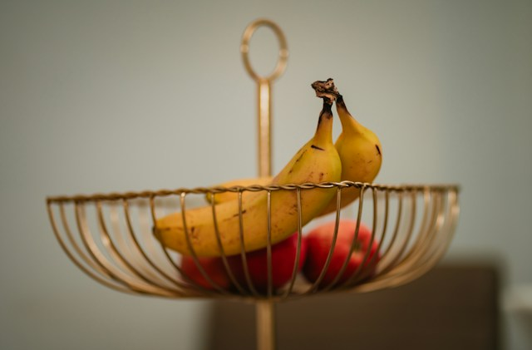

How much should I pay for the fruits given the following price list?


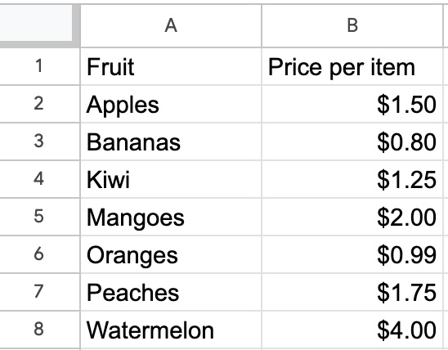


Answer the question through these steps:
Step 1: Identify what kind of fruits there are in the first image.
Step 2: Count the quantity of each fruit.
Step 3: For each grocery in first image, check the price of the grocery in the price list.
Step 4: Calculate the subtotal price for each type of fruit.
Step 5: Calculate the total price of fruits using the subtotals.

Answer and describe the steps taken:


-------Response--------
 **Step 1:** There are 3 apples and 2 bananas.
**Step 2:** The quantity of apples is 3 and the quantity of bananas is 2.
**Step 3:** The price of an apple is $1.50 and the price of a banana is $0.80.
**Step 4:** The subtotal price for apples is 3 * $1.50 = $4.50. The subtotal price for bananas is 2 * $0.80 = $1.60.
**Step 5:** The total price of fruits is $4.50 + $1.60 = $6.10.

The answer is $6.10.

In [4]:
image_grocery_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/banana-apple.jpg"
image_prices_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pricelist.jpg"
image_grocery = load_image_from_url(image_grocery_url)
image_prices = load_image_from_url(image_prices_url)

instructions = "Instructions: Consider the following image that contains fruits:"
prompt1 = "How much should I pay for the fruits given the following price list?"
prompt2 = """
Answer the question through these steps:
Step 1: Identify what kind of fruits there are in the first image.
Step 2: Count the quantity of each fruit.
Step 3: For each grocery in first image, check the price of the grocery in the price list.
Step 4: Calculate the subtotal price for each type of fruit.
Step 5: Calculate the total price of fruits using the subtotals.

Answer and describe the steps taken:
"""

contents = [
    instructions,
    image_grocery,
    prompt1,
    image_prices,
    prompt2,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Understanding Screens and Interfaces

Gemini can also extract information from appliance screens, UIs, screenshots, icons, and layouts.

For example, if you input an image of a stove, you can ask Gemini to provide instructions to help a user navigate the UI and respond in different languages:


-------Prompt--------


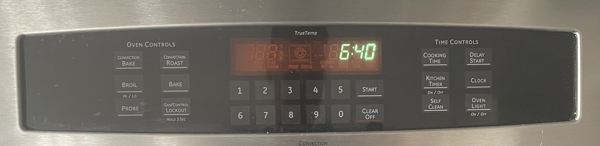

How can I reset the clock on this appliance?
Provide the instructions in English and French.
If instructions include buttons, also explain where those buttons are physically located.

JSON:


-------Response--------
 To reset the clock on this appliance, follow these steps:

1. Locate the "Clock" button on the control panel. It is located on the right side of the panel, below the "Delay Start" button.
2. Press and hold the "Clock" button for three seconds. The clock will begin to flash.
3. Use the number buttons to enter the correct time.
4. Press the "Clock" button again to save the new time.

The clock is now reset.

Pour réinitialiser l'horloge de cet appareil, suivez ces étapes :

1. Localisez le bouton « Clock » sur le panneau de commande. Il est situé sur le côté droit du panneau, sous le bouton « Delay Start ».
2. Appuyez sur le bouton « Clock » et maintenez-le enfoncé pendant trois secondes. L'horloge se mettra à clignoter.
3. Utilisez les boutons numériques pour entrer l'heure

In [5]:
image_stove_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/stove.jpg"
image_stove = load_image_from_url(image_stove_url)

prompt = """How can I reset the clock on this appliance?
Provide the instructions in English and French.
If instructions include buttons, also explain where those buttons are physically located.

JSON:
"""

contents = [image_stove, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

Note: The response may not be completely accurate, as the model may hallucinate; however, the model is able to identify the location of buttons and translate in a single query. To mitigate hallucinations, one approach is to ground the LLM with retrieval-augmented generation, which is outside the scope of this notebook.


## Understanding entity relationships in technical diagrams

Gemini has multimodal capabilities that enable it to understand diagrams and take actionable steps, such as optimization or code generation. This example demonstrates how Gemini can decipher an entity relationship (ER) diagram, understand the relationships between tables, identify requirements for optimization in a specific environment like BigQuery, and even generate corresponding code.


-------Prompt--------
Document the entities and relationships in this ER diagram.


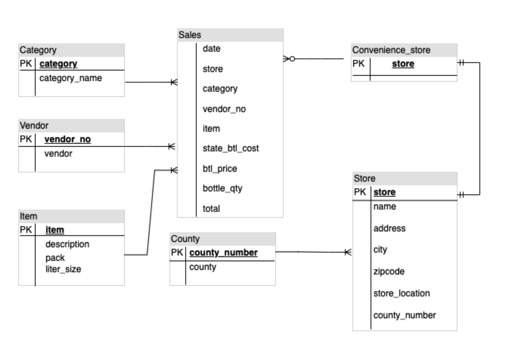


-------Response--------
 The ER diagram contains the following entities:

- Category
- Sales
- Convenience_store
- Vendor
- Item
- County
- Store

The ER diagram contains the following relationships:

- The Category entity has a one-to-many relationship with the Sales entity.
- The Convenience_store entity has a one-to-many relationship with the Sales entity.
- The Vendor entity has a one-to-many relationship with the Item entity.
- The Item entity has a one-to-many relationship with the Sales entity.
- The County entity has a one-to-many relationship with the Store entity.
- The Store entity has a one-to-many relationship with the Sales entity.

In [6]:
image_er_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/er.png"
image_er = load_image_from_url(image_er_url)

prompt = "Document the entities and relationships in this ER diagram."

contents = [prompt, image_er]

# Use a more deterministic configuration with a low temperature
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Recommendations based on multiple images

Gemini is capable of image comparison and providing recommendations. This may be useful in industries like e-commerce and retail.

Below is an example of choosing which pair of glasses would be better suited to an oval-shaped face:


-------Prompt--------

Which of these glasses you recommend for me based on the shape of my face?
I have an oval shape face.
----
Glasses 1:



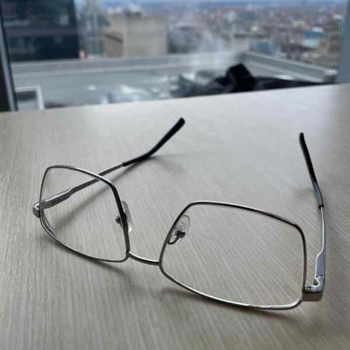


----
Glasses 2:



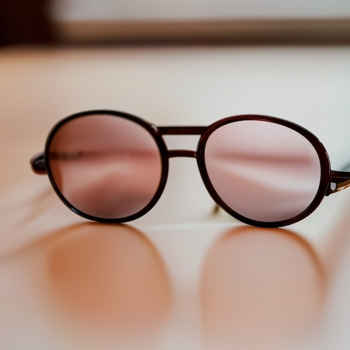


----
Explain how you reach out to this decision.
Provide your recommendation based on my face shape, and reasoning for each in JSON format.


-------Response--------
 ```json
{
  "recommendation": "Glasses 2",
  "reasoning": "Glasses 2 are better suited for an oval face shape because they have a rounded shape that will help to soften the angles of your face. The oval shape of the glasses will also help draw attention to your eyes, which are a focal point of your face."
}
```

In [7]:
image_glasses1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/glasses1.jpg"
image_glasses2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/glasses2.jpg"
image_glasses1 = load_image_from_url(image_glasses1_url)
image_glasses2 = load_image_from_url(image_glasses2_url)

prompt1 = """
Which of these glasses you recommend for me based on the shape of my face?
I have an oval shape face.
----
Glasses 1:
"""
prompt2 = """
----
Glasses 2:
"""
prompt3 = """
----
Explain how you reach out to this decision.
Provide your recommendation based on my face shape, and reasoning for each in JSON format.
"""

contents = [prompt1, image_glasses1, prompt2, image_glasses2, prompt3]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Similarity/Differences

Gemini can compare images and identify similarities or differences between objects.

The following example shows two scenes from Marienplatz in Munich, Germany that are slightly different. Gemini can compare between the images and find similarities/differences:


-------Prompt--------

Consider the following two images:
Image 1:



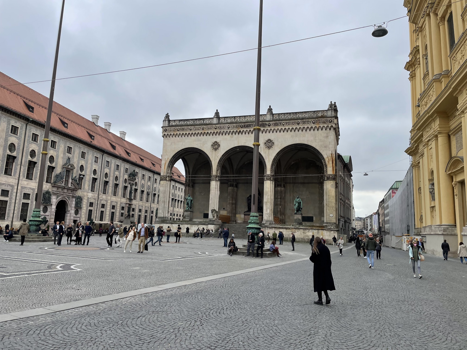


Image 2:



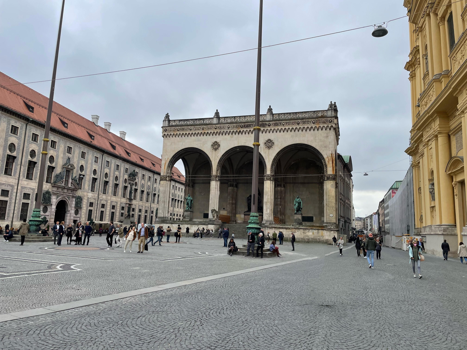


1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?


-------Response--------
 1. Image 1 shows a square in Munich, Germany. The square is surrounded by buildings, including the Feldherrnhalle, a loggia with statues of Bavarian rulers. There are also a number of people walking around the square.
2. Both images show the same square in Munich, Germany. The square is surrounded by the same buildings, including the Feldherrnhalle. There are also a number of people walking around the square.
3. The difference between Image 1 and Image 2 is that there are more people shown in Image 1. There are also some differences in the people shown in the two images. For example, the woman in the black coat in Image 1 is not shown in Image 2.

In [8]:
image_landmark1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark1.jpg"
image_landmark2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark2.jpg"
image_landmark1 = load_image_from_url(image_landmark1_url)
image_landmark2 = load_image_from_url(image_landmark2_url)

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?
"""

contents = [prompt1, image_landmark1, prompt2, image_landmark2, prompt3]

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Generating a video description

Gemini can also extract tags throughout a video:

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4

In [9]:
prompt = """
What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?




-------Response--------
 The video shows a beautiful coastline with a city on a cliff. The water is a crystal-clear blue and the waves are crashing against the shore. The city is full of white buildings and there is a long pier with boats docked along it.

You can see this in Antalya, Turkey.

The top 5 places in the world that look like this are:

1. Santorini, Greece
2. Positano, Italy
3. Amalfi Coast, Italy
4. Cinque Terre, Italy
5. Dubrovnik, Croatia

> You can confirm that the location is indeed Antalya, Turkey by visiting the Wikipedia page: https://en.wikipedia.org/wiki/Antalya


## Extracting tags of objects throughout the video

Gemini can also extract tags throughout a video.

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/photography.mp4


In [10]:
prompt = """
Answer the following questions using the video only:
- What is in the video?
- What is the action in the video?
- Provide 10 best tags for this video?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/photography.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
- What is in the video?
- What is the action in the video?
- Provide 10 best tags for this video?




-------Response--------
 - The video shows a man in a hat taking pictures of some artifacts on a table.
- The man is taking pictures of the artifacts.
- #photography, #art, #travel, #vacation, #beach, #sun, #sand, #water, #nature, #explore

## Asking more questions about a video

Below is another example of using Gemini to ask questions the video and return a JSON response.

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4  
> _Note: Although this video contains audio, Gemini does not currently support audio input and will only answer based on the video._

In [11]:
prompt = """
Answer the following questions using the video only:
What is the profession of the main person?
What are the main features of the phone highlighted?
Which city was this recorded in?
Provide the answer JSON.
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
What is the profession of the main person?
What are the main features of the phone highlighted?
Which city was this recorded in?
Provide the answer JSON.




-------Response--------
 ```json
{
  "profession": "photographer",
  "features": "Night Sight, Video Boost",
  "city": "Tokyo"
}
```

## Retrieving extra information beyond the video


> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/ottawatrain3.mp4


In [12]:
prompt = """
Which line is this?
where does it go?
What are the stations/stops?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/ottawatrain3.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Which line is this?
where does it go?
What are the stations/stops?




-------Response--------
 This is the O-Train Confederation Line. It is a light rail line that runs from Tunney's Pasture to Blair. The stations on the line are:

* Tunney's Pasture
* Bayview
* Pimisi
* Dominion
* Carleton
* Confederation
* City Hall
* Parliament
* Rideau
* uOttawa
* Lees
* Hurdman
* Cyrville
* St. Laurent
* Blair

> You can confirm that this is indeed the Confederation Line on Wikipedia here: https://en.wikipedia.org/wiki/Confederation_Line
